In [11]:
import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
sys.path.insert(0, PROJECT_ROOT)

sys.path.append(os.path.abspath(".."))


Trajectory shape: (64, 64, 64)


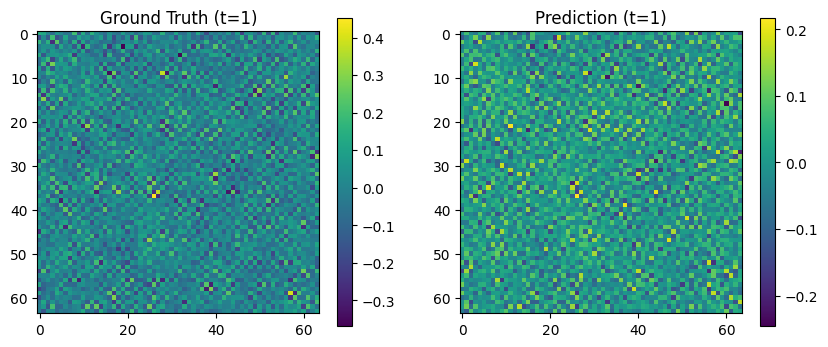

In [12]:
import sys, os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ===========================================
# FIX 1 — Tambahkan project root ke sys.path
# ===========================================
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, ROOT)

from physinet.model import PhysiNetOperator
from flax.serialization import from_bytes     # untuk load trained params

# ===========================================
# Load sample trajectory
# ===========================================
sample = np.load("../data/synthetic/wave2d_traj_00000.npz")
u = sample["u"]   # shape [T, H, W]
print("Trajectory shape:", u.shape)

# ===========================================
# Prepare input (multi-frame, seperti training)
# ===========================================
seq_len = 4
x_seq = u[:seq_len]                                  # [4, H, W]
x = jnp.array(x_seq)[None, ..., None]                # [1,4,H,W,1]
x_last = x[:, -1, :, :, :]                           # [1, H, W, 1]

# ===========================================
# Initialize model
# ===========================================
model = PhysiNetOperator(probabilistic=False)
rng = jax.random.PRNGKey(0)
params = model.init(rng, x_last)["params"]

# ===========================================
# FIX 2 — Load trained params (optional)
# ===========================================
if os.path.exists("../physinet_params.msgpack"):
    with open("../physinet_params.msgpack", "rb") as f:
        params = from_bytes(params, f.read())
else:
    print("WARNING: No trained params found. Using random init.")

# ===========================================
# Predict next frame
# ===========================================
outputs = model.apply({"params": params}, x_last)
pred = outputs["mean"][0, ..., 0]

# ===========================================
# Plotting
# ===========================================
plt.figure(figsize=(10,4))

# Ground truth t=1
plt.subplot(1,2,1)
plt.title("Ground Truth (t=1)")
plt.imshow(u[1], cmap="viridis")
plt.colorbar()

# Prediction
plt.subplot(1,2,2)
plt.title("Prediction (t=1)")
plt.imshow(np.array(pred), cmap="viridis")
plt.colorbar()

plt.show()


Cell 1 — Setup & Import

In [13]:
import sys, os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Tambahkan root project agar bisa import physinet/*
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, ROOT)

from physinet.model import PhysiNetOperator
from flax.serialization import from_bytes


Cell 2 — Load Trajectory

In [14]:
# Load trajectory
sample = np.load("../data/synthetic/wave2d_traj_00000.npz")
u = sample["u"]
print("Trajectory shape:", u.shape)


Trajectory shape: (64, 64, 64)


Cell 3 — Load Trained Model

In [15]:
# Input last frame from the first 4 frames
seq_len = 4
x_seq = u[:seq_len]
x = jnp.array(x_seq)[None, ..., None]
x_last = x[:, -1, :, :, :]

# Initialize model
model = PhysiNetOperator(probabilistic=False)
rng = jax.random.PRNGKey(0)
params = model.init(rng, x_last)["params"]

# Load trained params
ckpt_path = "../physinet_params.msgpack"

if os.path.exists(ckpt_path):
    print("Loading trained model...")
    with open(ckpt_path, "rb") as f:
        params = from_bytes(params, f.read())
else:
    print("WARNING: trained params not found, using random params.")


Loading trained model...


Cell 4 — Predict t+1

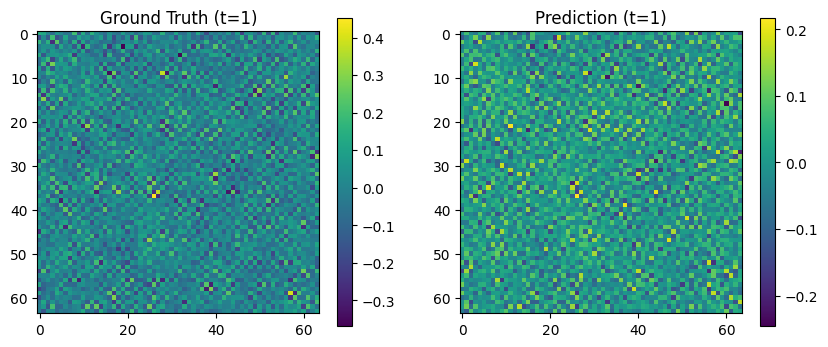

In [16]:
outputs = model.apply({"params": params}, x_last)
pred = outputs["mean"][0, ..., 0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Ground Truth (t=1)")
plt.imshow(u[1], cmap="viridis")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Prediction (t=1)")
plt.imshow(np.array(pred), cmap="viridis")
plt.colorbar()

plt.show()


Cell 5 — Multi-step Rollout Function

In [17]:
def rollout(model, params, u0, steps=20):
    preds = []
    x = jnp.array(u0)[None, ..., None]

    for _ in range(steps):
        out = model.apply({"params": params}, x)
        pred = out["mean"][0, ..., 0]
        preds.append(np.array(pred))
        x = pred[None, ..., None]

    return np.stack(preds, axis=0)


Cell 6 — Perform Rollout

In [18]:
roll = rollout(model, params, u0=u[0], steps=20)
roll.shape


(20, 64, 64)

Cell 7 — Visualize GT vs Rollout

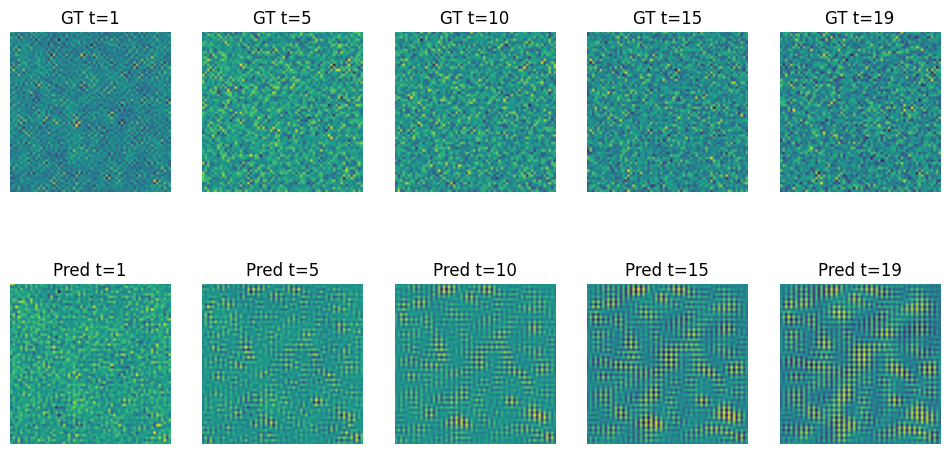

In [19]:
plt.figure(figsize=(12,6))
for i, t in enumerate([1,5,10,15,19]):
    plt.subplot(2,5,i+1)
    plt.title(f"GT t={t}")
    plt.imshow(u[t], cmap="viridis")
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.title(f"Pred t={t}")
    plt.imshow(roll[t-1], cmap="viridis")
    plt.axis("off")

plt.show()
